# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
from uu import encode

import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

from scipy.signal import spectrogram
from scipy.fft import fft, fftfreq

from loadmydata.load_molene_meteo import load_molene_meteo_dataset
import pandas as pd
from math import asin, cos, radians, sin, sqrt
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

from pygsp import graphs
import geopandas
import contextily as cx

rng = np.random.default_rng()

/var/folders/m9/xmtphkx904b8hxdxrgm2jnz80000gn/T/ipykernel_45871/333837221.py:3: DeprecationWarning: 'uu' is deprecated and slated for removal in Python 3.13
  from uu import encode


# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [3]:
signal, symbols = X_train[3], y_train[3]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

A * A 6 5 D 5 C


##### Symbol extraction from signal

In [4]:
#frequencies from the DTMF telephone keypad
low_frequencies = [697, 770, 852, 941]
high_frequencies = [1209, 1336, 1477, 1633]

frequencies_to_symbol = {
        (697, 1209): "1",
        (697, 1336): "2",
        (697, 1477): "3",
        (697, 1633): "A",
        (770, 1209): "4",
        (770, 1336): "5",
        (770, 1477): "6",
        (770, 1633): "B",
        (852, 1209): "7",
        (852, 1336): "8",
        (852, 1477): "9",
        (852, 1633): "C",
        (941, 1209): "*",
        (941, 1336): "0",
        (941, 1477): "#",
        (941, 1633): "D"
    }

def split_signal(signal, symbol_number):
    """
    find breakpoints using a change-point detection algorithm to find the starts and ends of the symbols and silences
    
    :param 
    signal: input signal to process
    symbol_number: number of symbols used to encode the signal
    """
    
    frequencies, times, Sxx = spectrogram(signal, FS)
    signal_power = np.sum(Sxx, axis=0)
    breakpoints_indexes = rpt.Dynp(model="l2", jump = 1).fit_predict(signal_power, 2*symbol_number)
    breakpoints = [int(times[breakpoint_index-1]*FS) for breakpoint_index in breakpoints_indexes]
    return [signal[breakpoints[2*i]:breakpoints[2*i+1]] for i in range(len(breakpoints)//2)]


def find_frequencies_from_signal(signal):
    """return the frequencies f1 and f2 detected in the signal"""
    N = len(signal)
    signal_fft = fft(signal)
    frequencies_fft = fftfreq(N, 1/FS)[:N//2]
    magnitudes_fft = abs(signal_fft)[:N//2]
    # Find the two highest peaks in the magnitude spectrum
    peaks_indices = np.argsort(magnitudes_fft)[-2:]  # Get indices of the two largest peaks
    f1_detected = frequencies_fft[min(peaks_indices)]
    f2_detected = frequencies_fft[max(peaks_indices)]
    return f1_detected, f2_detected

def symbol_from_frequencies(f1_detected, f2_detected):
    # Find the closest frequency to f1_detected
    f1 = min(low_frequencies, key=lambda f: abs(f - f1_detected))
    f2 = min(high_frequencies, key=lambda f: abs(f - f2_detected))
    return frequencies_to_symbol[(f1,f2)]

In [5]:
def symbols_from_signal(signal, symbol_number):
    """find symbols from a signal"""
    signals = split_signal(signal, symbol_number)
    return ' '.join([symbol_from_frequencies(*find_frequencies_from_signal(s)) for s in signals])

In [6]:
print("symbols predicted: ", symbols_from_signal(signal, len(symbols)))
print("ground truth symbols: ", ' '.join(symbols))

symbols predicted:  A * A 6 5 D 5 C
ground truth symbols:  A * A 6 5 D 5 C


# Question 2

In [7]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()

In [8]:
signal, symbols = X_test[0], y_test[0]
IPython.display.Audio(signal, rate=FS)
print("symbols predicted for the test sample number 1: ", symbols_from_signal(signal, len(symbols)))
print("ground truth symbols for the test sample number 1: ", ' '.join(symbols))

symbols predicted for the test sample number 1:  7 2 3 C 9 9
ground truth symbols for the test sample number 1:  7 2 1 C 9 9


In [9]:
signal, symbols = X_test[1], y_test[1]
IPython.display.Audio(signal, rate=FS)
print("symbols predicted for the test sample number 2: ", symbols_from_signal(signal, len(symbols)))
print("ground truth symbols for the test sample number 2: ", ' '.join(symbols))

symbols predicted for the test sample number 2:  1 # 2 #
ground truth symbols for the test sample number 2:  1 # 2 #


# Question 3

In [10]:
def g_U(l, R, a):
    if l < 0 and l >= -R*a:
        return 1/2*(1 + np.cos(2*np.pi*(l/(a*R) + 1/2)))
    else:
        return 0
    
def g(l, R, a, m):
    return g_U(l -a*m, R, a)

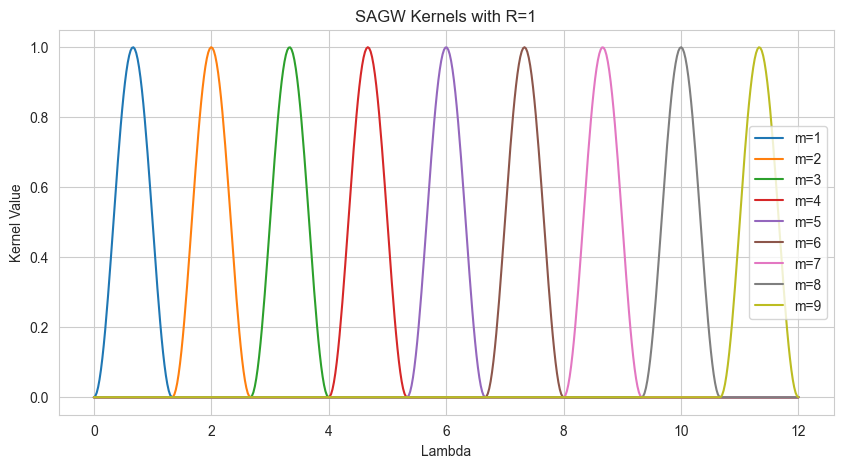

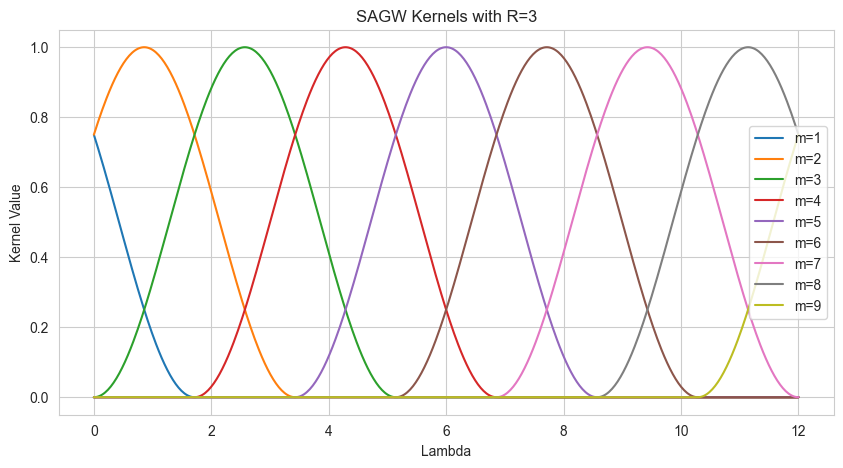

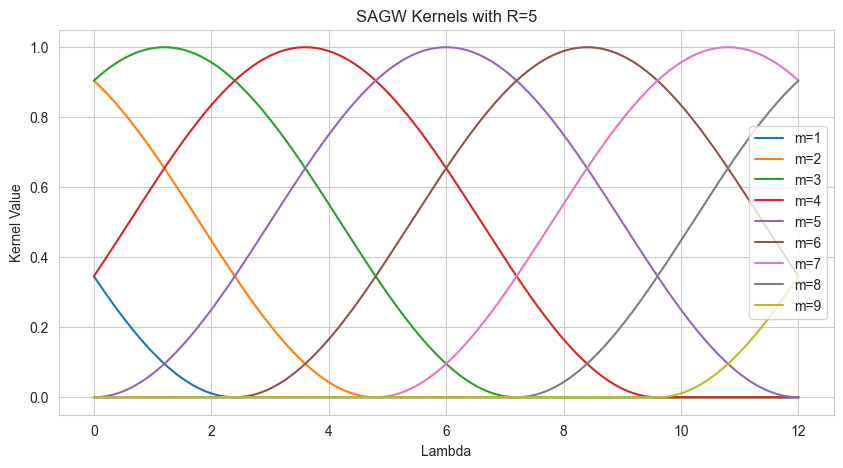

In [11]:
M = 9
lambda_n = 12
R_values = [1, 3, 5]

lambdas = np.linspace(0, lambda_n, 500)
for R in R_values:
    plt.figure(figsize=(10, 5))
    for m in range(1, M + 1):
        g_m = np.array([g(l, R, lambda_n /(M + 1 - R), m) for l in lambdas])
        plt.plot(lambdas, g_m, label=f'm={m}')
        
    plt.title(f'SAGW Kernels with R={R}')
    plt.xlabel('Lambda')
    plt.ylabel('Kernel Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Question 4

##### Load dataset

In [12]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [13]:
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")

##### Remove all stations with missing values in the temperature

In [14]:
missing_df = pd.DataFrame(temperature_df.isna().mean(axis=0).sort_values(ascending=False), columns=['missing_temperature_proportion'])
print('Stations with temperature missing values:', missing_df[missing_df['missing_temperature_proportion']!=0])

Stations with temperature missing values:                     missing_temperature_proportion
station_name                                      
BATZ                                      1.000000
BEG_MEIL                                  1.000000
CAMARET                                   1.000000
PLOUGONVELIN                              1.000000
RIEC SUR BELON                            0.193548
ST NAZAIRE-MONTOIR                        0.094086
PLOUAY-SA                                 0.084677
VANNES-MEUCON                             0.067204
LANNAERO                                  0.049731
PLOUDALMEZEAU                             0.002688
LANDIVISIAU                               0.001344
SIZUN                                     0.001344
QUIMPER                                   0.001344
OUESSANT-STIFF                            0.001344
LANVEOC                                   0.001344
ARZAL                                     0.001344
BREST-GUIPAVAS                          

In [15]:
stations_to_keep = missing_df[missing_df['missing_temperature_proportion']==0].index
temperature_df = temperature_df[stations_to_keep]
cleaned_stations_df = stations_df[stations_df['Nom'].isin(stations_to_keep)]

##### Utilities function

In [16]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """
    lon1, lat1 = point_1
    lon2, lat2 = point_2
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

##### Choose the minimum threshold so that the network is connected and the average degree is at least 3

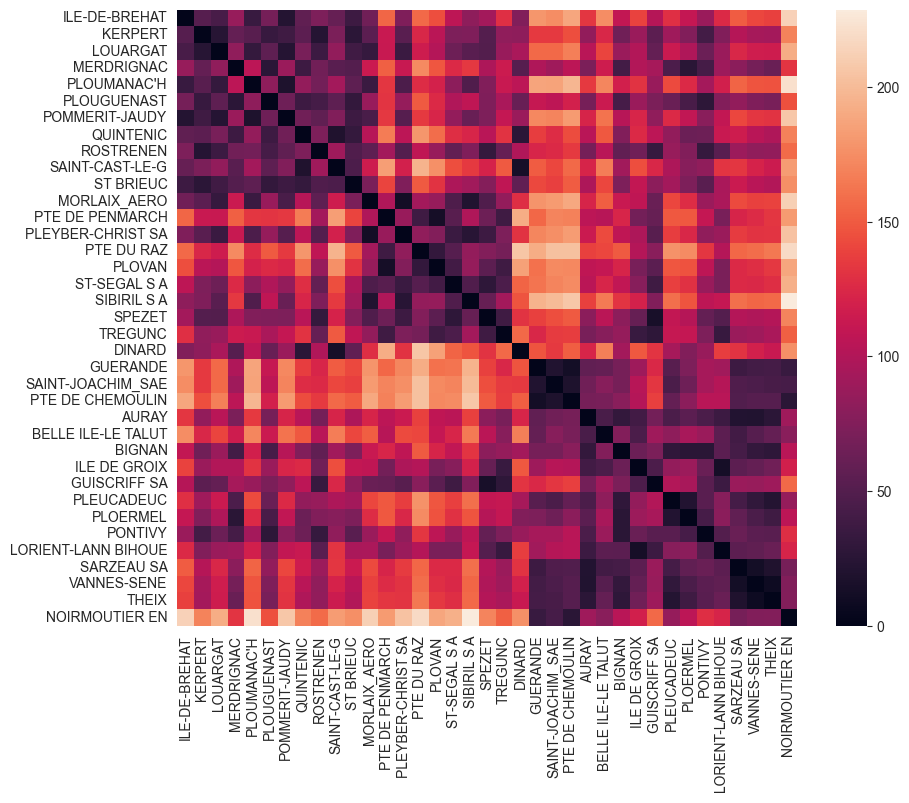

In [17]:
stations_np = cleaned_stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=cleaned_stations_df.Nom,
    yticklabels=cleaned_stations_df.Nom,
    ax=ax,
)

stations_gdf = geopandas.GeoDataFrame(
    cleaned_stations_df,
    geometry=geopandas.points_from_xy(cleaned_stations_df.Longitude, cleaned_stations_df.Latitude),
).set_crs("EPSG:4326")

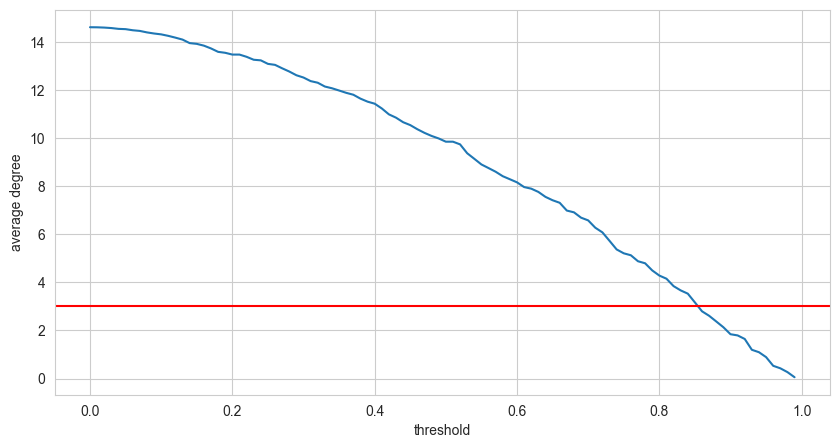

Average degree = 3.66 and is connected:True. Threshold of 0.83


In [18]:
sigma = np.median(dist_mat_condensed) 
thresholds = np.arange(0, 1, 0.01)

degrees = []
for threshold in thresholds : 
	adj_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
	degrees.append(np.mean(adj_matrix.sum(axis=1)))

plt.figure(figsize=(10,5))
plt.plot(thresholds,degrees)
plt.axhline(y=3, color='red')
plt.xlabel('threshold')
plt.ylabel('average degree')
plt.show()

for threshold in reversed(thresholds):
	adj_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
	G = graphs.Graph(adj_matrix)
	degree = np.mean(adj_matrix.sum(axis=1))
	if G.is_connected(recompute=True) and degree >= 3 :
		print(f"Average degree = {degree:.2f} and is connected:{G.is_connected(recompute=True)}. Threshold of {threshold:.2f}")
		break

##### Compute the smoothness of the signal

In [19]:
best_threshold = threshold

adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, best_threshold)
)

G_gaussian = graphs.Graph(adjacency_matrix_gaussian)

The smoothest signal is at 2014-01-24 19:00:00
The least smooth signal is at 2014-01-21 06:00:00


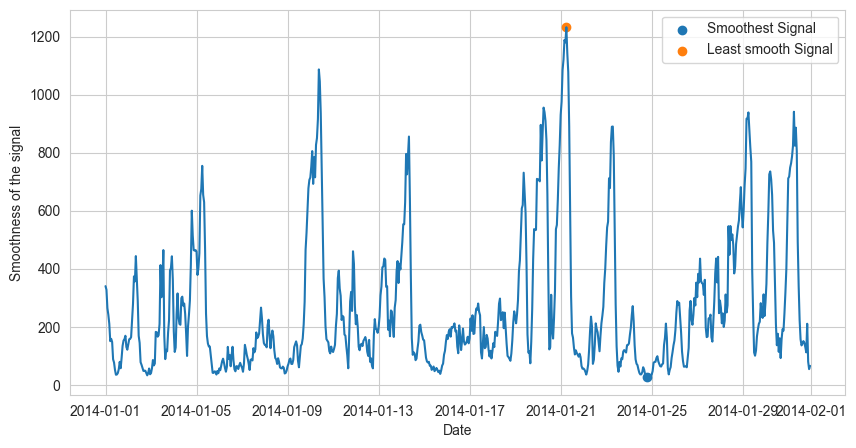

In [20]:
smoothness = [row.dot(G_gaussian.L.todense() @ row) for (_, row) in temperature_df.iterrows()]

plt.figure(figsize=(10, 5))
plt.plot(temperature_df.index, smoothness)
plt.scatter(temperature_df.index[np.argmin(smoothness)], np.min(smoothness), label = 'Smoothest Signal')
plt.scatter(temperature_df.index[np.argmax(smoothness)], np.max(smoothness), label = 'Least smooth Signal')
plt.xlabel('Date')
plt.ylabel('Smoothness of the signal')
plt.legend()

date_min_smoothness = temperature_df.index[np.argmin(smoothness)]
print(f"The smoothest signal is at {date_min_smoothness}")

date_max_smoothness = temperature_df.index[np.argmax(smoothness)]
print(f"The least smooth signal is at {date_max_smoothness}")

# Question 5

In [21]:
Laplacian_matrix = G_gaussian.L.todense()
eigen_values, eigen_vectors = np.linalg.eig(Laplacian_matrix)
eigen_values = np.real(eigen_values)

#sort eigenvalues
idx = np.argsort(eigen_values)
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:, idx]

M = 9
R = 3

def node_classification(date):
    f = temperature_df.loc[temperature_df.index == date].to_numpy()
    f_hat = eigen_vectors.T @ f.T #Graph Fourier Transform
    node_labels = []
    for vertex in range(len(f_hat)):
        W_v = []
        for m in range(1, M+1):
            W = 0
            for l in range(len(eigen_values)):
                W += g(eigen_values[l], R, eigen_values[-1] /(M + 1 - R), m) * f_hat[l] * eigen_vectors[vertex, l]  
            W_v.append(W)
        node_labels.append(np.argmax([sum(np.abs(W_v[:3]) ** 2), sum(np.abs(W_v[3:6]) ** 2), sum(np.abs(W_v[6:]) ** 2)]))
    
    ax = stations_gdf.geometry.plot(figsize=(20, 10))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    G.set_coordinates(stations_np)
    G.plot_signal(np.array(node_labels), ax = ax)

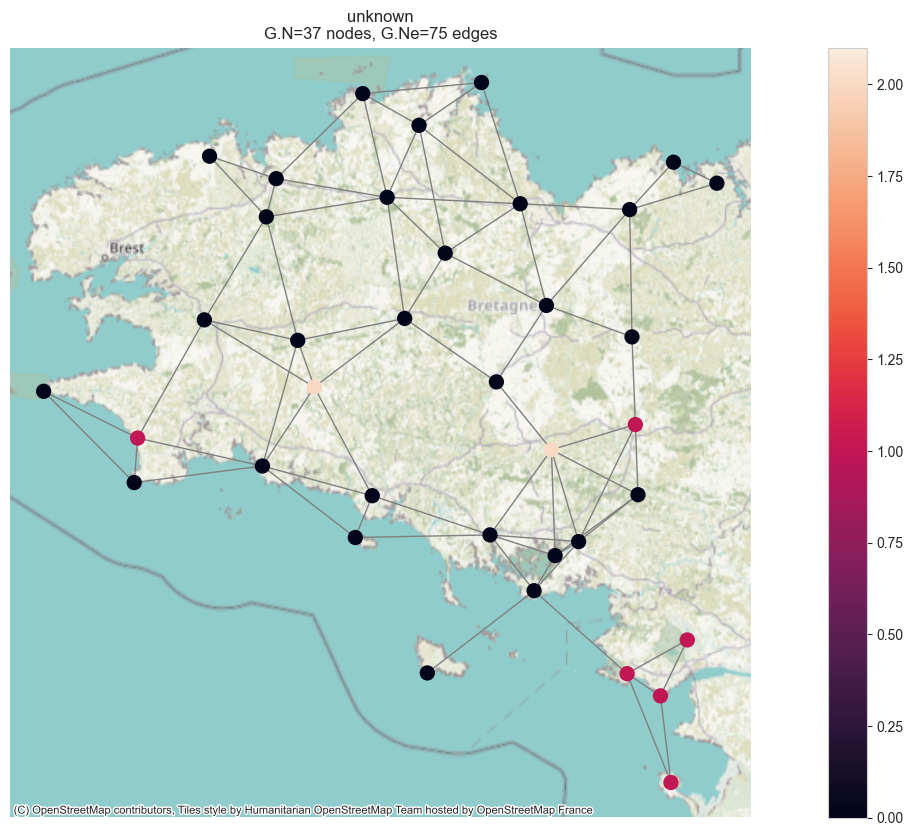

In [22]:
node_classification(date_max_smoothness)

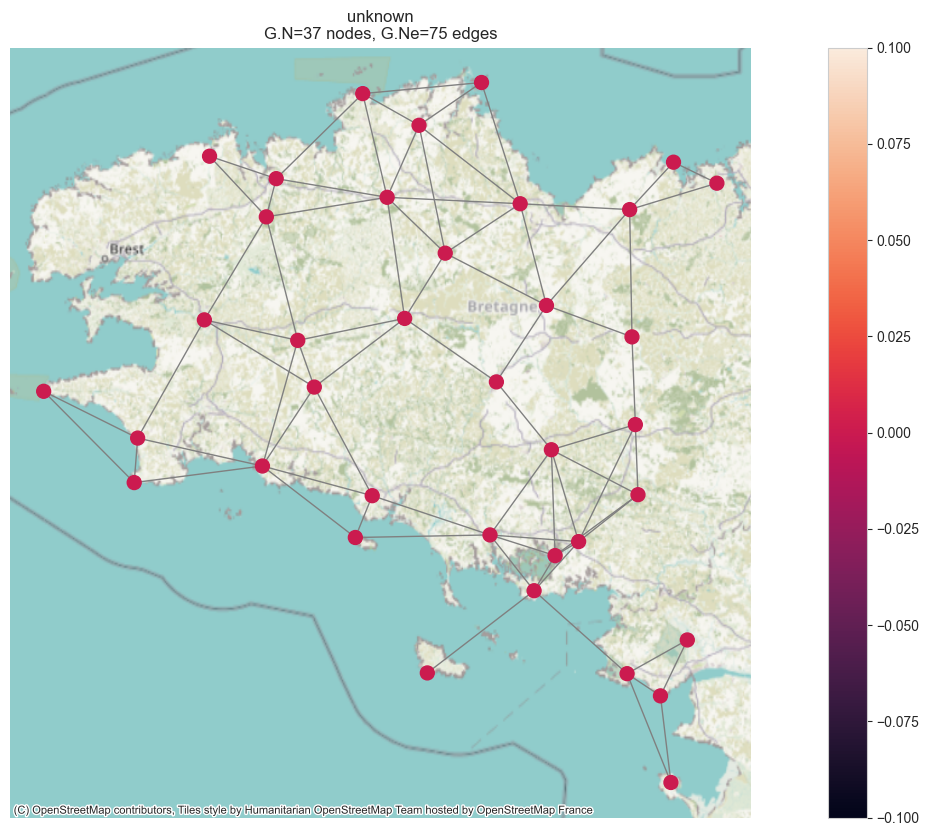

In [23]:
node_classification(date_min_smoothness)

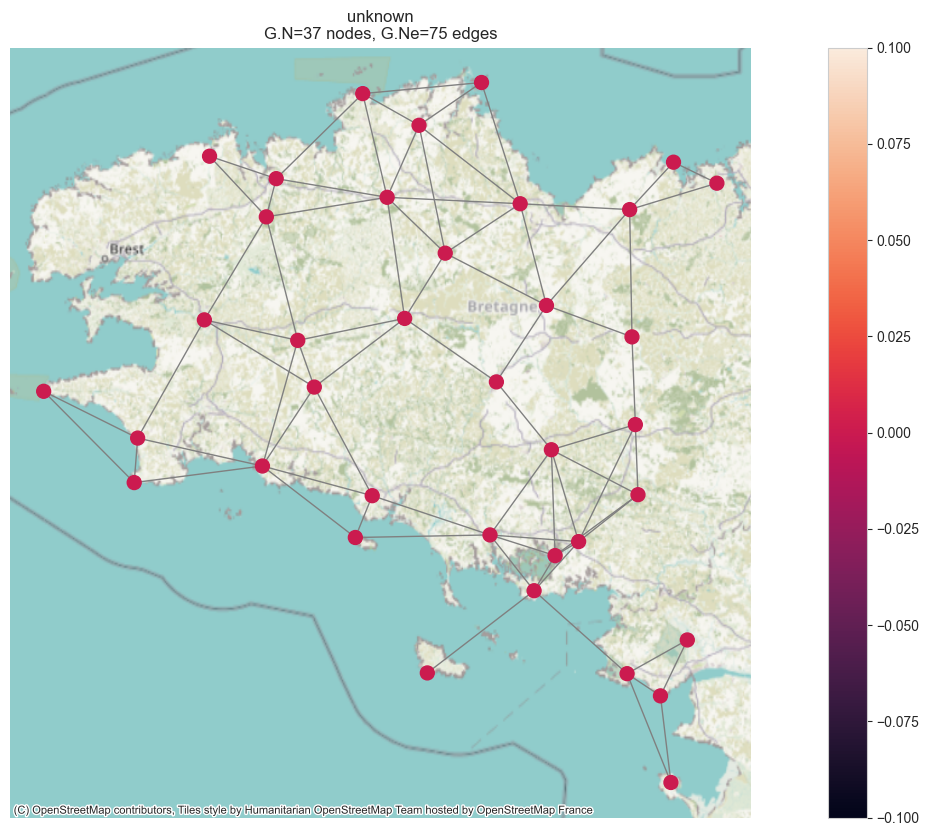

In [24]:
node_classification(temperature_df.index[0])

# Question 6

In [25]:
def biggest_class(date):
    f = temperature_df.loc[temperature_df.index == date].to_numpy()
    f_hat = eigen_vectors.T @ f.T #Graph Fourier Transform
    node_labels = []
    for vertex in range(len(f_hat)):
        W_v = []
        for m in range(1, M+1):
            W = 0
            for l in range(len(eigen_values)):
                W += g(eigen_values[l], R, eigen_values[-1] /(M + 1 - R), m) * f_hat[l] * eigen_vectors[vertex, l]  
            W_v.append(W)
        node_labels.append(np.argmax([sum(np.abs(W_v[:3]) ** 2), sum(np.abs(W_v[3:6]) ** 2), sum(np.abs(W_v[6:]) ** 2)]))
    low = node_labels.count(0)
    medium = node_labels.count(1)
    high = node_labels.count(2)
    return np.argmax([low, medium, high])
temp_mean = np.mean(temperature_df,axis=1)
low,medium,high = [],[],[]
n=0
for i in temperature_df.index:
    major_class = biggest_class(i)
    if major_class == 0:
        low.append([i,n])
    if major_class == 1:
        medium.append([i,n])
    if major_class == 2:
        high.append([i,n])
    n += 1


In [26]:
biggest_class(date_max_smoothness)

np.int64(0)

In [27]:
low = np.array(low)
medium = np.array(medium)
high = np.array(high)

/var/folders/m9/xmtphkx904b8hxdxrgm2jnz80000gn/T/ipykernel_45871/572934274.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(low[:,0], temp_mean[low[:,1]], label = 'low_frequency')


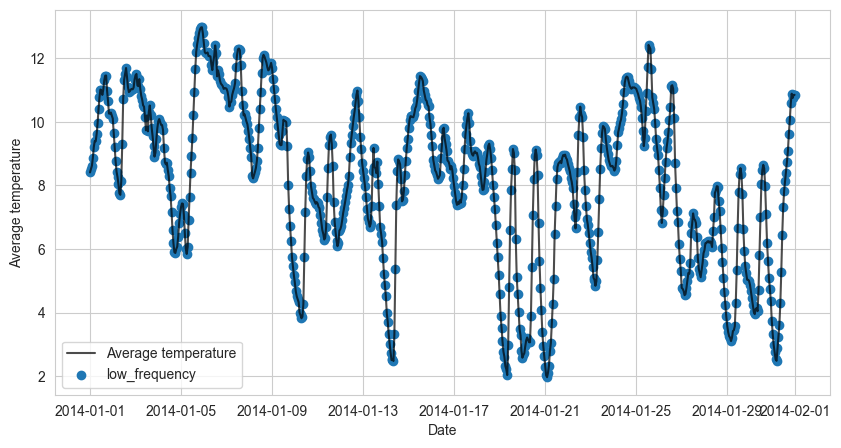

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(temperature_df.index, temp_mean, 'black',alpha = 0.7, label='Average temperature')
if len(low) > 0:
    plt.scatter(low[:,0], temp_mean[low[:,1]], label = 'low_frequency')
if len(medium) > 0:
    plt.scatter(medium[:,0], temp_mean[medium[:,1]], label = 'medium_frequency')
if len(high) > 0:
    plt.scatter(high[:,0], temp_mean[high[:,1]], label = 'high_frequency')
plt.xlabel('Date')
plt.ylabel('Average temperature')
plt.legend()

# Question 7

In [29]:
m = len(temperature_df.index)
laplacian_gprime = 2 * np.eye(m) - np.eye(m,k=1) - np.eye(m,k=-1)
eigen_values_prime, eigen_vectors_prime = np.linalg.eig(laplacian_gprime)

eigen_values_h = []
for lamb in eigen_values_prime:
    for mu in eigen_values:
        eigen_values_h.append(mu * lamb)
eigen_values_h = np.array(eigen_values_h)

eigen_vectors_h = []
for Y in eigen_vectors_prime:
    for X in eigen_vectors:
        eigen_vectors_h.append(np.kron(Y, X))
eigen_vectors_h = np.array(eigen_vectors_h)

In [30]:
eigen_vectors_h = eigen_vectors_h[:,0,:]

In [37]:
f = temperature_df.loc[:].to_numpy().flatten()
f_hat = eigen_vectors_h.T @ f.T
node_labels = []
for vertex in range(len(f_hat)):
        W_v = []
        for m in range(1, M+1):
            W = 0
            for l in range(len(eigen_values_h)):
                W += g(eigen_values_h[l], R, eigen_values_h[-1] /(M + 1 - R), m) * f_hat[l] * eigen_vectors_h[vertex, l]  
            W_v.append(W)
        node_labels.append(np.argmax([sum(np.abs(W_v[:3]) ** 2), sum(np.abs(W_v[3:6]) ** 2), sum(np.abs(W_v[6:]) ** 2)]))


In [54]:
n = len(eigen_values)
low, medium, high = [],[],[]
for i in range(len(temperature_df.index)):
    count_low = node_labels[i*n:(i+1)*n].count(0)
    count_medium = node_labels[i*n:(i+1)*n].count(1)
    count_high = node_labels[i*n:(i+1)*n].count(2)
    major_class = np.argmax([count_low, count_medium, count_high])
    if major_class == 0:
        low.append([i])
    if major_class == 1:
        medium.append([i])
    if major_class == 2:
        high.append([i])

In [57]:
low = np.array(low)
low = low.reshape(low.shape[0])
medium = np.array(medium)
medium = medium.reshape(medium.shape[0])
high = np.array(high)
high = high.reshape(high.shape[0])

/var/folders/m9/xmtphkx904b8hxdxrgm2jnz80000gn/T/ipykernel_45871/671085033.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(temperature_df.index[low], temp_mean[low], label = 'low_frequency')


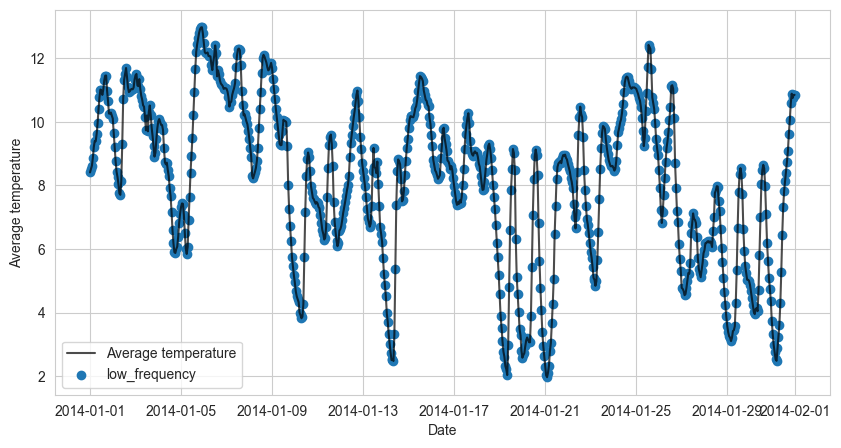

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(temperature_df.index, temp_mean, 'black',alpha = 0.7, label='Average temperature')
if len(low) > 0:
    plt.scatter(temperature_df.index[low], temp_mean[low], label = 'low_frequency')
if len(medium) > 0:
    plt.scatter(temperature_df.index[medium], temp_mean[medium], label = 'medium_frequency')
if len(high) > 0:
    plt.scatter(temperature_df.index[high], temp_mean[high], label = 'high_frequency')
plt.xlabel('Date')
plt.ylabel('Average temperature')
plt.legend()